In [1]:
!pip install transformers gradio seaborn matplotlib wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import gradio as gr
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


In [4]:
# Load Dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_json(next(iter(uploaded))).T  # Load JSON file

Saving sarcasm_data.json to sarcasm_data.json


In [5]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [6]:
# Apply Cleaning
df['utterance'] = df['utterance'].apply(clean_text)
df['context'] = df['context'].apply(lambda x: [clean_text(c) for c in x])
df = df[['utterance', 'context', 'sarcasm']]


In [7]:
# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['utterance'], df['sarcasm'], test_size=0.2, random_state=42)

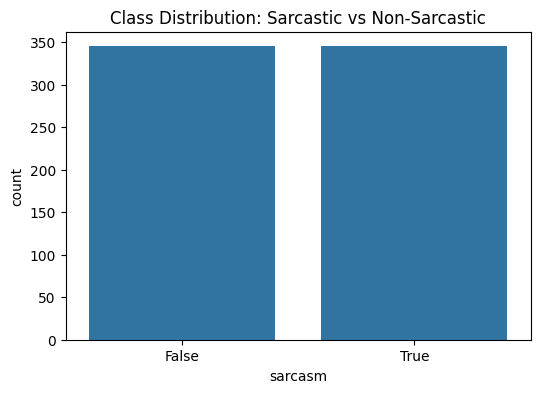

In [8]:
# Visualize class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['sarcasm'])
plt.title("Class Distribution: Sarcastic vs Non-Sarcastic")
plt.show()

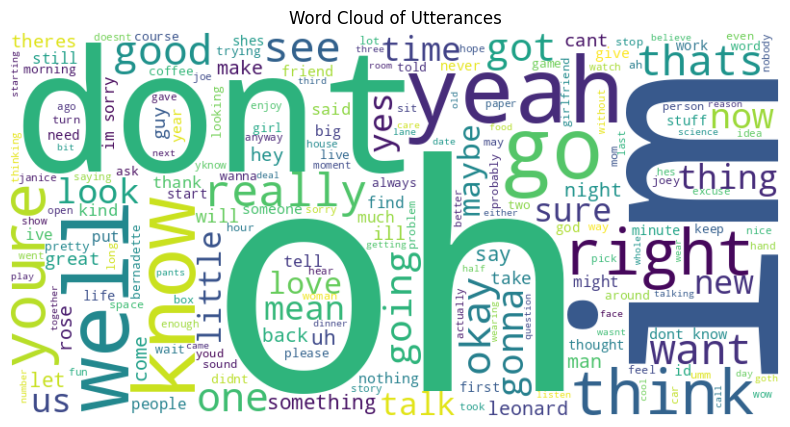

In [9]:
# Generate and display a word cloud for all utterances
from wordcloud import WordCloud
all_text = " ".join(df['utterance'])
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Utterances")
plt.show()

In [10]:
# Fine-Tune RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

train_dataset = SarcasmDataset(train_encodings, train_labels.tolist())
val_dataset = SarcasmDataset(val_encodings, val_labels.tolist())


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [11]:
# Verify label shape before training
print("Label shape:", train_dataset[0]["labels"].shape)
print("Example label:", train_dataset[0]["labels"])


Label shape: torch.Size([])
Example label: tensor(0)


In [13]:
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()

    # Ensure labels is a NumPy array
    if not isinstance(labels, np.ndarray):
        labels = labels.cpu().numpy() if isinstance(labels, torch.Tensor) else np.array(labels)

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    cm = confusion_matrix(labels, predictions)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(labels, predictions))

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        "accuracy": float(acc),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1)
    }

In [14]:
# Training arguments
training_args = TrainingArguments(
    report_to="none",
    output_dir='./results',
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="steps",
    logging_dir="./logs",
    eval_steps=500
)

model_bert = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train(resume_from_checkpoint=False)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=207, training_loss=0.5394303695015286, metrics={'train_runtime': 974.8426, 'train_samples_per_second': 1.699, 'train_steps_per_second': 0.212, 'total_flos': 62122986836640.0, 'train_loss': 0.5394303695015286, 'epoch': 3.0})

Confusion Matrix:
 [[31 22]
 [42 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.58      0.49        53
           1       0.66      0.51      0.57        85

    accuracy                           0.54       138
   macro avg       0.54      0.55      0.53       138
weighted avg       0.57      0.54      0.54       138



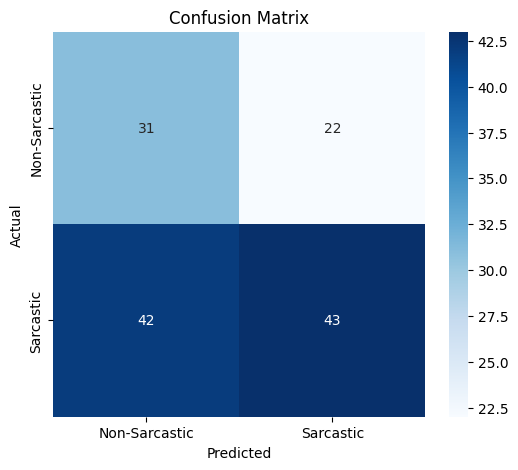

{'eval_loss': 1.3096977472305298, 'eval_accuracy': 0.5362318840579711, 'eval_precision': 0.6615384615384615, 'eval_recall': 0.5058823529411764, 'eval_f1': 0.5733333333333334, 'eval_runtime': 14.7474, 'eval_samples_per_second': 9.358, 'eval_steps_per_second': 1.221, 'epoch': 3.0}


In [15]:
metrics = trainer.evaluate()
print(metrics)

Confusion Matrix:
 [[31 22]
 [42 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.58      0.49        53
           1       0.66      0.51      0.57        85

    accuracy                           0.54       138
   macro avg       0.54      0.55      0.53       138
weighted avg       0.57      0.54      0.54       138



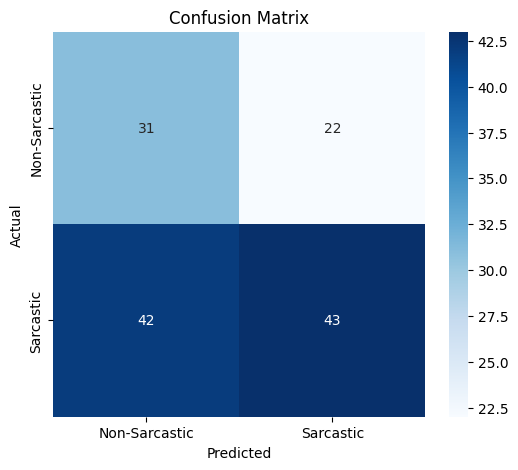

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shivam-wangikar (shivam-wangikar-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 1.3096977472305298, 'eval_model_preparation_time': 0.0026, 'eval_accuracy': 0.5362318840579711, 'eval_precision': 0.6615384615384615, 'eval_recall': 0.5058823529411764, 'eval_f1': 0.5733333333333334, 'eval_runtime': 14.6978, 'eval_samples_per_second': 9.389, 'eval_steps_per_second': 1.225}
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6233821cb9f2983ebd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [16]:
# Save Model & Tokenizer
model_bert.save_pretrained("sarcasm_roberta_model")
tokenizer.save_pretrained("sarcasm_roberta_model")

# ipython-input-10-c0ad97b481b2 (updated)
from transformers import TrainingArguments, Trainer  # Make sure these are imported

# Prepare the entire dataset for final training (same as in ipython-input-8-c0ad97b481b2)
all_texts = df['utterance']
all_labels = df['sarcasm']
all_encodings = tokenizer(list(all_texts), truncation=True, padding=True, max_length=128)
final_dataset = SarcasmDataset(all_encodings, all_labels.tolist())

# Split the final dataset into train and evaluation sets (same as in previous solution)
from sklearn.model_selection import train_test_split
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=42  # 20% for evaluation
)

eval_encodings = tokenizer(list(eval_texts), truncation=True, padding=True, max_length=128)
final_eval_dataset = SarcasmDataset(eval_encodings, eval_labels.tolist())

# Load the pretrained model and tokenizer
model_path = "/content/sarcasm_roberta_model" # The path where you saved your model
final_model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

# Set up training arguments (only for evaluation)
eval_training_args = TrainingArguments(
    output_dir='./eval_results',
    per_device_eval_batch_size=8,

)

# Create a Trainer for evaluation
eval_trainer = Trainer(
    model=final_model,
    args=eval_training_args,
    eval_dataset=final_eval_dataset,
    compute_metrics=compute_metrics
)

# Evaluate the model
metrics = eval_trainer.evaluate()
print(metrics)

# Test the trained model
def test_model(text):
    inputs = tokenizer(text, return_tensors="pt")
    output = model_bert(**inputs)
    return "Sarcastic" if output.logits.argmax() == 1 else "Non-Sarcastic"

# Gradio Web App
gr.Interface(fn=test_model, inputs="text", outputs="label").launch(share=True)
